In [ ]:
import pandas as pd
import os
import requests
from PIL import Image
from io import BytesIO
import random

In [ ]:
!pip install torchvision

  Using cached typing_extensions-4.12.2-py3-none-any.whl.metadata (3.0 kB)
  Using cached sympy-1.13.1-py3-none-any.whl.metadata (12 kB)
   ---------------------------------------- 1.6/1.6 MB 4.5 MB/s eta 0:00:00
   ---------------------------------------- 203.1/203.1 MB 3.9 MB/s eta 0:00:00
Using cached sympy-1.13.1-py3-none-any.whl (6.2 MB)
Using cached typing_extensions-4.12.2-py3-none-any.whl (37 kB)
  Attempting uninstall: typing-extensions
    Found existing installation: typing_extensions 4.5.0
    Uninstalling typing_extensions-4.5.0:
      Successfully uninstalled typing_extensions-4.5.0
  Attempting uninstall: sympy
    Found existing installation: sympy 1.12
    Uninstalling sympy-1.12:
      Successfully uninstalled sympy-1.12
  Attempting uninstall: torch
    Found existing installation: torch 2.1.1
    Uninstalling torch-2.1.1:
      Successfully uninstalled torch-2.1.1


  You can safely remove it manually.

[notice] A new release of pip is available: 23.3.1 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
!pip install rarfile

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision import transforms, models
from sklearn.metrics import accuracy_score
import os
import rarfile
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt


In [ ]:
import rarfile

# آدرس فایل RAR
rar_file_path = "/content/drive/My Drive/good_images.rar"

# باز کردن فایل RAR
with rarfile.RarFile(rar_file_path) as rf:
    rf.extractall("/content/images_files/")


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, datasets, models
from sklearn.model_selection import train_test_split
import os
from PIL import Image
import numpy as np
from sklearn.metrics import accuracy_score


#func



In [ ]:

# تعریف تنظیمات و پارامترها
IMAGE_SIZE = 128
BATCH_SIZE = 24
EPOCHS = 5
LEARNING_RATE = 0.00001

In [ ]:

# 1. آماده‌سازی داده‌ها
class CustomDataset(Dataset):
    def __init__(self, image_dir, transform=None):
        self.image_dir = image_dir
        self.transform = transform
        self.images = []
        self.labels = []
        self.categories = os.listdir(image_dir)

        # خواندن تصاویر و برچسب‌ها
        for label, category in enumerate(self.categories):
            category_path = os.path.join(image_dir, category)
            for image_name in os.listdir(category_path):
                if image_name.endswith(".jpg") or image_name.endswith(".png"):
                    self.images.append(os.path.join(category_path, image_name))
                    self.labels.append(label)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images[idx]
        label = self.labels[idx]
        img = Image.open(img_path).convert("RGB")

        if self.transform:
            img = self.transform(img)

        return img, label

# تعریف transform‌ها برای داده‌ها
transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor()
    #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# بارگذاری داده‌ها
image_dir = "/content/images_files/good_images"
dataset = CustomDataset(image_dir, transform)

In [ ]:
from sklearn.model_selection import train_test_split

# تقسیم داده‌ها: ابتدا Train و Temporary (Validation + Test)
train_data, temp_data = train_test_split(dataset, test_size=0.3, stratify=dataset.labels)

# تقسیم Temporary به Validation و Test
val_data, test_data = train_test_split(temp_data, test_size=0.5, stratify=[d[1] for d in temp_data])

# ایجاد DataLoader‌ها
train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)


In [ ]:
# تابع آموزش مدل
def train_model_with_validation(model, train_loader, val_loader, criterion, optimizer, epochs=EPOCHS):
    train_losses = []
    val_losses = []
    val_accuracies = []

    for epoch in range(epochs):
        model.train()
        train_loss = 0

        # آموزش روی داده‌های Train
        for images, labels in train_loader:
            images, labels = images.to("cuda"), labels.to("cuda")
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        train_losses.append(train_loss / len(train_loader))

        # ارزیابی روی داده‌های Validation
        model.eval()
        val_loss = 0
        all_preds = []
        all_labels = []
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to("cuda"), labels.to("cuda")
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, preds = torch.max(outputs, 1)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        val_losses.append(val_loss / len(val_loader))
        val_accuracy = accuracy_score(all_labels, all_preds)
        val_accuracies.append(val_accuracy * 100)

        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}, Val Accuracy: {val_accuracy * 100:.2f}%")

    return train_losses, val_losses, val_accuracies


#کشف مدل و ترین و سعی و خطا

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import timm
from torch.utils.data import DataLoader
from tqdm import tqdm

# فرض می‌کنیم که train_loader و test_loader از قبل تعریف شده‌اند

# تعریف مدل‌ها
models_dict = {
    'mobilenet_v2': 'mobilenetv2_100',
    'efficientnet_b0': 'efficientnet_b0',
    'resnet18': 'resnet18',
    'resnet50': 'resnet50',
    'densenet121': 'densenet121',
    'efficientnet_b3': 'efficientnet_b3',
    'inception_v3': 'inception_v3',
    'xception': 'xception',
    'efficientnet_b7': 'efficientnet_b7',
    'vit_b16': 'vit_base_patch16_224',
    'swin_base': 'swin_base_patch4_window7_224',
    'convnext_base': 'convnext_base',
    'beit_base': 'beit_base_patch16_224',
}

# تابع برای ارزیابی مدل
def evaluate_model_on_test(model, test_loader):
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0
    criterion = nn.CrossEntropyLoss()

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.cuda(), labels.cuda()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    test_loss /= len(test_loader)
    test_accuracy = 100 * correct / total
    return test_loss, test_accuracy

# تابع آموزش مدل
def train_model(model, train_loader, criterion, optimizer, num_epochs=5):
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        for inputs, labels in tqdm(train_loader, desc=f'Epoch {epoch + 1}/{num_epochs}'):
            inputs, labels = inputs.cuda(), labels.cuda()
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}')

# انتخاب بهترین مدل
best_model = None
best_accuracy = 0
best_model_name = ""
for model_name, model_arch in models_dict.items():
    print(f"\nTraining {model_name}...")
    # بارگذاری مدل
    model = timm.create_model(model_arch, pretrained=True)

    # تغییر لایه کلاسیفایر مدل برای تعداد کلاس‌های داده‌های شما
    if hasattr(model, 'classifier'):
        num_features = model.classifier.in_features
        model.classifier = nn.Linear(num_features, len(set(dataset.labels)))
    elif hasattr(model, 'fc'):
        num_features = model.fc.in_features
        model.fc = nn.Linear(num_features, len(set(dataset.labels)))
    else:
        # برای مدل‌هایی که ویژگی‌های کلاس خاص دارند، این بخش را اضافه کنید
        num_features = model.head.fc.in_features if hasattr(model, 'head') else model.head.in_features
        model.head.fc = nn.Linear(num_features, len(set(dataset.labels))) if hasattr(model.head, 'fc') else nn.Linear(num_features, len(set(dataset.labels)))

    # انتقال مدل به GPU
    model = model.to("cuda")

    # تعریف Criterion و Optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.0001)

    # آموزش مدل
    train_model(model, train_loader, criterion, optimizer, num_epochs=5)

    # ارزیابی مدل روی داده‌های تست
    test_loss, test_accuracy = evaluate_model_on_test(model, test_loader)

    print(f"Test Accuracy for {model_name}: {test_accuracy:.2f}%")

    # ذخیره مدل با بهترین دقت
    if test_accuracy > best_accuracy:
        best_accuracy = test_accuracy
        best_model = model
        best_model_name = model_name

# نمایش بهترین مدل
print(f"\nBest Model: {best_model_name} with Test Accuracy: {best_accuracy:.2f}%")



Training mobilenet_v2...


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/14.2M [00:00<?, ?B/s]

RuntimeError: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx

In [ ]:
#good
# تعریف مدل
efficientnet_model = models.efficientnet_b7(weights='IMAGENET1K_V1')
num_features = efficientnet_model.classifier[1].in_features
num_classes = len(set(dataset.labels))  # تعداد کلاس‌ها (بر اساس داده‌های شما)
efficientnet_model.classifier[1] = nn.Linear(num_features, num_classes)
efficientnet_model = efficientnet_model.to("cuda")

# تعریف Criterion و Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(efficientnet_model.parameters(), lr=0.00003)

# آموزش مدل
train_losses, val_losses, val_accuracies = train_model_with_validation(
    efficientnet_model, train_loader, val_loader, criterion, optimizer
)



Epoch 1/10, Train Loss: 1.7363, Val Loss: 0.9682, Val Accuracy: 72.63%
Epoch 2/10, Train Loss: 0.7677, Val Loss: 0.5459, Val Accuracy: 84.18%
Epoch 3/10, Train Loss: 0.4582, Val Loss: 0.4304, Val Accuracy: 86.38%
Epoch 4/10, Train Loss: 0.2768, Val Loss: 0.3744, Val Accuracy: 87.73%
Epoch 5/10, Train Loss: 0.1685, Val Loss: 0.3832, Val Accuracy: 87.41%
Epoch 6/10, Train Loss: 0.1086, Val Loss: 0.3759, Val Accuracy: 87.80%
Epoch 7/10, Train Loss: 0.0688, Val Loss: 0.3718, Val Accuracy: 88.38%
Epoch 8/10, Train Loss: 0.0563, Val Loss: 0.3851, Val Accuracy: 88.64%
Epoch 9/10, Train Loss: 0.0497, Val Loss: 0.4048, Val Accuracy: 88.32%


In [ ]:
# ذخیره مدل
torch.save(efficientnet_model.state_dict(), 'efficientnet_model.pth')


In [ ]:
import torch.nn as nn
import torch.optim as optim
from torchvision import models

# تعریف مدل
efficientnet_model = models.efficientnet_b7(weights='IMAGENET1K_V1')

# فریز کردن تمام لایه‌های backbone
for param in efficientnet_model.parameters():
    param.requires_grad = False

# فعال کردن آموزش برای لایه‌های آخر
# EfficientNet به طور معمول لایه‌های classifier را در بخش classifier دارد
# و شما می‌خواهید 5 لایه آخر آن را آموزش دهید.

# لایه‌های classifier که باید آموزش داده شوند
for param in efficientnet_model.classifier.parameters():
    param.requires_grad = True

# تنظیم تعداد ویژگی‌ها و کلاس‌ها
num_features = efficientnet_model.classifier[1].in_features
num_classes = len(set(dataset.labels))  # تعداد کلاس‌ها (بر اساس داده‌های شما)

# تغییر لایه classifier برای تعداد کلاس‌های شما
efficientnet_model.classifier[1] = nn.Linear(num_features, num_classes)

# انتقال مدل به GPU
efficientnet_model = efficientnet_model.to("cuda")

# تعریف Criterion و Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(efficientnet_model.parameters(), lr=0.00003)

# آموزش مدل
train_losses, val_losses, val_accuracies = train_model_with_validation(
    efficientnet_model, train_loader, val_loader, criterion, optimizer
)


Epoch 1/50, Train Loss: 2.2776, Val Loss: 2.2342, Val Accuracy: 23.63%
Epoch 2/50, Train Loss: 2.1687, Val Loss: 2.1504, Val Accuracy: 37.19%
Epoch 3/50, Train Loss: 2.0781, Val Loss: 2.0761, Val Accuracy: 45.32%
Epoch 4/50, Train Loss: 1.9971, Val Loss: 2.0020, Val Accuracy: 50.87%
Epoch 5/50, Train Loss: 1.9212, Val Loss: 1.9380, Val Accuracy: 54.03%
Epoch 6/50, Train Loss: 1.8553, Val Loss: 1.8769, Val Accuracy: 56.36%
Epoch 7/50, Train Loss: 1.7879, Val Loss: 1.8225, Val Accuracy: 57.46%
Epoch 8/50, Train Loss: 1.7274, Val Loss: 1.7764, Val Accuracy: 58.36%
Epoch 9/50, Train Loss: 1.6798, Val Loss: 1.7314, Val Accuracy: 58.81%
Epoch 10/50, Train Loss: 1.6363, Val Loss: 1.6922, Val Accuracy: 59.26%
Epoch 11/50, Train Loss: 1.5943, Val Loss: 1.6536, Val Accuracy: 60.17%
Epoch 12/50, Train Loss: 1.5618, Val Loss: 1.6138, Val Accuracy: 60.81%
Epoch 13/50, Train Loss: 1.5189, Val Loss: 1.5822, Val Accuracy: 60.88%
Epoch 14/50, Train Loss: 1.4896, Val Loss: 1.5556, Val Accuracy: 61.01%
E

KeyboardInterrupt: 

In [ ]:
# تعریف مدل
efficientnet_model = models.efficientnet_b0(weights='IMAGENET1K_V1')
num_features = efficientnet_model.classifier[1].in_features
num_classes = len(set(dataset.labels))  # تعداد کلاس‌ها (بر اساس داده‌های شما)
efficientnet_model.classifier[1] = nn.Linear(num_features, num_classes)
efficientnet_model = efficientnet_model.to("cuda")

# تعریف Criterion و Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(efficientnet_model.parameters(), lr=0.001)

# آموزش مدل
train_losses, val_losses, val_accuracies = train_model_with_validation(
    efficientnet_model, train_loader, val_loader, criterion, optimizer
)




Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 201MB/s]


Epoch 1/50, Train Loss: 1.5366, Val Loss: 1.4121, Val Accuracy: 52.89%
Epoch 2/50, Train Loss: 1.1946, Val Loss: 1.2635, Val Accuracy: 56.50%
Epoch 3/50, Train Loss: 0.9947, Val Loss: 1.3290, Val Accuracy: 55.89%
Epoch 4/50, Train Loss: 0.8173, Val Loss: 1.3748, Val Accuracy: 56.72%
Epoch 5/50, Train Loss: 0.6814, Val Loss: 1.5410, Val Accuracy: 54.94%
Epoch 6/50, Train Loss: 0.5476, Val Loss: 1.5287, Val Accuracy: 56.94%
Epoch 7/50, Train Loss: 0.4626, Val Loss: 1.6114, Val Accuracy: 57.44%
Epoch 8/50, Train Loss: 0.3645, Val Loss: 1.8385, Val Accuracy: 56.22%
Epoch 9/50, Train Loss: 0.3204, Val Loss: 1.9841, Val Accuracy: 55.39%
Epoch 10/50, Train Loss: 0.2823, Val Loss: 2.0183, Val Accuracy: 55.61%
Epoch 11/50, Train Loss: 0.2432, Val Loss: 2.0323, Val Accuracy: 56.78%
Epoch 12/50, Train Loss: 0.2036, Val Loss: 2.1882, Val Accuracy: 56.50%
Epoch 13/50, Train Loss: 0.2030, Val Loss: 2.1155, Val Accuracy: 57.39%
Epoch 14/50, Train Loss: 0.2017, Val Loss: 2.2395, Val Accuracy: 54.56%
E

In [ ]:
#good
# ارزیابی روی داده‌های Test
def evaluate_model_on_test(model, test_loader):
    model.eval()
    test_loss = 0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to("cuda"), labels.to("cuda")
            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    test_accuracy = accuracy_score(all_labels, all_preds)
    print(f"Test Loss: {test_loss / len(test_loader):.4f}, Test Accuracy: {test_accuracy * 100:.2f}%")
    return test_loss / len(test_loader), test_accuracy * 100

test_loss, test_accuracy = evaluate_model_on_test(efficientnet_model, test_loader)

Test Loss: 0.8370, Test Accuracy: 82.07%


In [ ]:
# ارزیابی روی داده‌های Test
def evaluate_model_on_test(model, test_loader):
    model.eval()
    test_loss = 0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to("cuda"), labels.to("cuda")
            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    test_accuracy = accuracy_score(all_labels, all_preds)
    print(f"Test Loss: {test_loss / len(test_loader):.4f}, Test Accuracy: {test_accuracy * 100:.2f}%")
    return test_loss / len(test_loader), test_accuracy * 100

test_loss, test_accuracy = evaluate_model_on_test(efficientnet_model, test_loader)


Test Loss: 2.9826, Test Accuracy: 55.50%


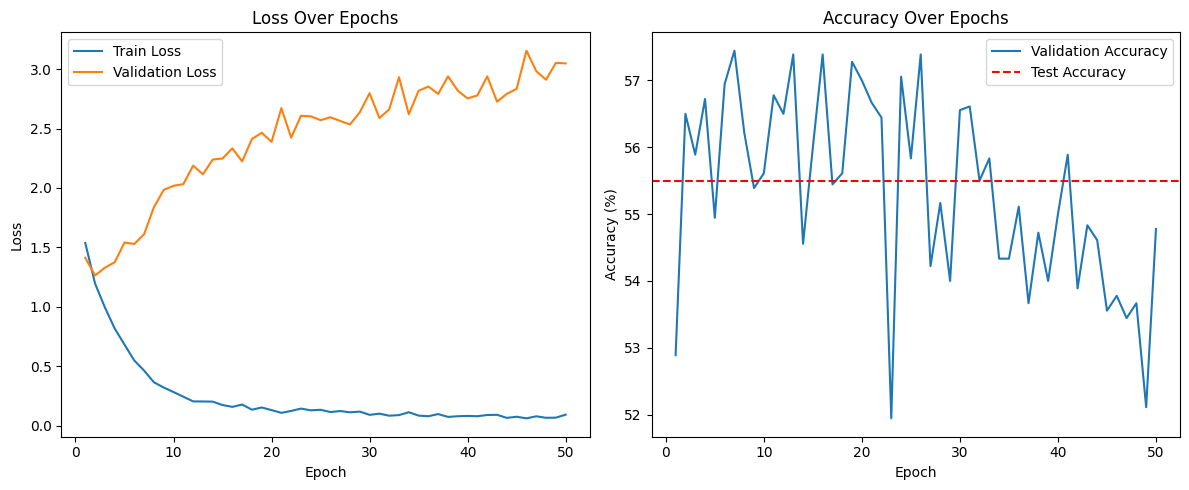

In [ ]:
# رسم نمودار دقت و Loss
def plot_metrics(train_losses, val_losses, val_accuracies, test_accuracy):
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(12, 5))

    # نمودار Loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label="Train Loss")
    plt.plot(epochs, val_losses, label="Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Loss Over Epochs")
    plt.legend()

    # نمودار Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, val_accuracies, label="Validation Accuracy")
    plt.axhline(y=test_accuracy, color='r', linestyle='--', label="Test Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy (%)")
    plt.title("Accuracy Over Epochs")
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_metrics(train_losses, val_losses, val_accuracies, test_accuracy)


In [ ]:
#good
from sklearn.metrics import classification_report

# ارزیابی مدل EfficientNet-B0 با نمایش دقت هر دسته
def evaluate_efficientnet_model_per_category(model, test_loader):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to("cuda" if torch.cuda.is_available() else "cpu"), labels.to("cuda" if torch.cuda.is_available() else "cpu")
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # نمایش دقت کلی
    accuracy = accuracy_score(all_labels, all_preds)
    print(f"Overall Accuracy: {accuracy * 100:.2f}%")

    # نمایش دقت هر دسته با استفاده از classification_report
    category_names = dataset.categories  # نام دسته‌ها از داده‌ها
    report = classification_report(all_labels, all_preds, target_names=category_names)
    print("\nCategory-wise Accuracy:\n", report)

# فراخوانی تابع ارزیابی
evaluate_efficientnet_model_per_category(efficientnet_model, test_loader)

Overall Accuracy: 82.07%

Category-wise Accuracy:
               precision    recall  f1-score   support

         248       0.96      0.92      0.94       168
         365       0.72      0.68      0.70       177
         242       0.91      0.94      0.93       179
         403       0.77      0.79      0.78       179
         321       0.68      0.61      0.64       178
         311       0.91      0.88      0.89       133
         358       0.86      0.90      0.88       175
         357       0.89      0.86      0.88       167
         372       0.61      0.68      0.64       173
         300       0.94      0.96      0.95       178

    accuracy                           0.82      1707
   macro avg       0.82      0.82      0.82      1707
weighted avg       0.82      0.82      0.82      1707



In [ ]:
from sklearn.metrics import classification_report

# ارزیابی مدل EfficientNet-B0 با نمایش دقت هر دسته
def evaluate_efficientnet_model_per_category(model, test_loader):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to("cuda" if torch.cuda.is_available() else "cpu"), labels.to("cuda" if torch.cuda.is_available() else "cpu")
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # نمایش دقت کلی
    accuracy = accuracy_score(all_labels, all_preds)
    print(f"Overall Accuracy: {accuracy * 100:.2f}%")

    # نمایش دقت هر دسته با استفاده از classification_report
    category_names = dataset.categories  # نام دسته‌ها از داده‌ها
    report = classification_report(all_labels, all_preds, target_names=category_names)
    print("\nCategory-wise Accuracy:\n", report)

# فراخوانی تابع ارزیابی
evaluate_efficientnet_model_per_category(efficientnet_model, test_loader)

Overall Accuracy: 55.50%

Category-wise Accuracy:
               precision    recall  f1-score   support

         326       0.37      0.36      0.36       180
         365       0.54      0.62      0.57       180
         322       0.36      0.57      0.44       180
         312       0.73      0.52      0.60       180
         311       0.54      0.73      0.62       180
         315       0.56      0.49      0.53       180
         321       0.39      0.17      0.23       180
         313       0.77      0.69      0.73       180
         324       0.74      0.75      0.75       180
         325       0.63      0.66      0.64       180

    accuracy                           0.56      1800
   macro avg       0.56      0.56      0.55      1800
weighted avg       0.56      0.56      0.55      1800



In [ ]:
#good
from torchvision import models
import torch.nn as nn
import torch.optim as optim

# تعریف مدل
efficientnet_model = models.efficientnet_b4(weights='IMAGENET1K_V1')  # استفاده از EfficientNet-B4
num_features = efficientnet_model.classifier[1].in_features
num_classes = len(set(dataset.labels))  # تعداد کلاس‌ها (بر اساس داده‌های شما)
efficientnet_model.classifier[1] = nn.Linear(num_features, num_classes)
efficientnet_model = efficientnet_model.to("cuda")

# تعریف Criterion و Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(efficientnet_model.parameters(), lr=0.0001)  # کاهش Learning Rate برای مدل بزرگ‌تر

# آموزش مدل
train_losses, val_losses, val_accuracies = train_model_with_validation(
    efficientnet_model, train_loader, val_loader, criterion, optimizer
)

Downloading: "https://download.pytorch.org/models/efficientnet_b4_rwightman-23ab8bcd.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b4_rwightman-23ab8bcd.pth
100%|██████████| 74.5M/74.5M [00:00<00:00, 104MB/s]


Epoch 1/20, Train Loss: 1.7158, Val Loss: 0.9881, Val Accuracy: 72.70%
Epoch 2/20, Train Loss: 0.7871, Val Loss: 0.6370, Val Accuracy: 78.79%
Epoch 3/20, Train Loss: 0.5948, Val Loss: 0.6195, Val Accuracy: 80.67%
Epoch 4/20, Train Loss: 0.4865, Val Loss: 0.5968, Val Accuracy: 81.37%
Epoch 5/20, Train Loss: 0.4045, Val Loss: 0.5463, Val Accuracy: 82.37%
Epoch 6/20, Train Loss: 0.3475, Val Loss: 0.5315, Val Accuracy: 83.13%
Epoch 7/20, Train Loss: 0.2803, Val Loss: 0.5601, Val Accuracy: 82.89%
Epoch 8/20, Train Loss: 0.2452, Val Loss: 0.5047, Val Accuracy: 83.95%
Epoch 9/20, Train Loss: 0.2043, Val Loss: 0.5070, Val Accuracy: 85.06%
Epoch 10/20, Train Loss: 0.1625, Val Loss: 0.5281, Val Accuracy: 85.12%


KeyboardInterrupt: 

In [ ]:
from torchvision import models
import torch.nn as nn
import torch.optim as optim

# تعریف مدل
efficientnet_model = models.efficientnet_b4(weights='IMAGENET1K_V1')  # استفاده از EfficientNet-B4
num_features = efficientnet_model.classifier[1].in_features
num_classes = len(set(dataset.labels))  # تعداد کلاس‌ها (بر اساس داده‌های شما)
efficientnet_model.classifier[1] = nn.Linear(num_features, num_classes)
efficientnet_model = efficientnet_model.to("cuda")

# تعریف Criterion و Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(efficientnet_model.parameters(), lr=0.0001)  # کاهش Learning Rate برای مدل بزرگ‌تر

# آموزش مدل
train_losses, val_losses, val_accuracies = train_model_with_validation(
    efficientnet_model, train_loader, val_loader, criterion, optimizer
)

Downloading: "https://download.pytorch.org/models/efficientnet_b4_rwightman-23ab8bcd.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b4_rwightman-23ab8bcd.pth
100%|██████████| 74.5M/74.5M [00:00<00:00, 173MB/s]


Epoch 1/50, Train Loss: 2.0859, Val Loss: 1.7184, Val Accuracy: 45.56%
Epoch 2/50, Train Loss: 1.5148, Val Loss: 1.4157, Val Accuracy: 51.72%
Epoch 3/50, Train Loss: 1.2844, Val Loss: 1.3110, Val Accuracy: 55.78%
Epoch 4/50, Train Loss: 1.1440, Val Loss: 1.2656, Val Accuracy: 56.72%
Epoch 5/50, Train Loss: 1.0321, Val Loss: 1.2303, Val Accuracy: 57.67%
Epoch 6/50, Train Loss: 0.9357, Val Loss: 1.2211, Val Accuracy: 59.00%
Epoch 7/50, Train Loss: 0.8394, Val Loss: 1.2336, Val Accuracy: 58.28%
Epoch 8/50, Train Loss: 0.7390, Val Loss: 1.2630, Val Accuracy: 58.56%
Epoch 9/50, Train Loss: 0.6646, Val Loss: 1.2973, Val Accuracy: 58.67%
Epoch 10/50, Train Loss: 0.5651, Val Loss: 1.3220, Val Accuracy: 59.44%
Epoch 11/50, Train Loss: 0.5022, Val Loss: 1.3967, Val Accuracy: 59.78%
Epoch 12/50, Train Loss: 0.4222, Val Loss: 1.4936, Val Accuracy: 60.50%
Epoch 13/50, Train Loss: 0.3725, Val Loss: 1.5515, Val Accuracy: 60.11%
Epoch 14/50, Train Loss: 0.3246, Val Loss: 1.6141, Val Accuracy: 60.50%
E

In [ ]:
#good
# ارزیابی روی داده‌های Test
def evaluate_model_on_test(model, test_loader):
    model.eval()
    test_loss = 0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to("cuda"), labels.to("cuda")
            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    test_accuracy = accuracy_score(all_labels, all_preds)
    print(f"Test Loss: {test_loss / len(test_loader):.4f}, Test Accuracy: {test_accuracy * 100:.2f}%")
    return test_loss / len(test_loader), test_accuracy * 100

test_loss, test_accuracy = evaluate_model_on_test(efficientnet_model, test_loader)

Test Loss: 0.4649, Test Accuracy: 86.88%


In [ ]:
# ارزیابی روی داده‌های Test
def evaluate_model_on_test(model, test_loader):
    model.eval()
    test_loss = 0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to("cuda"), labels.to("cuda")
            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    test_accuracy = accuracy_score(all_labels, all_preds)
    print(f"Test Loss: {test_loss / len(test_loader):.4f}, Test Accuracy: {test_accuracy * 100:.2f}%")
    return test_loss / len(test_loader), test_accuracy * 100

test_loss, test_accuracy = evaluate_model_on_test(efficientnet_model, test_loader)


Test Loss: 2.4605, Test Accuracy: 62.00%


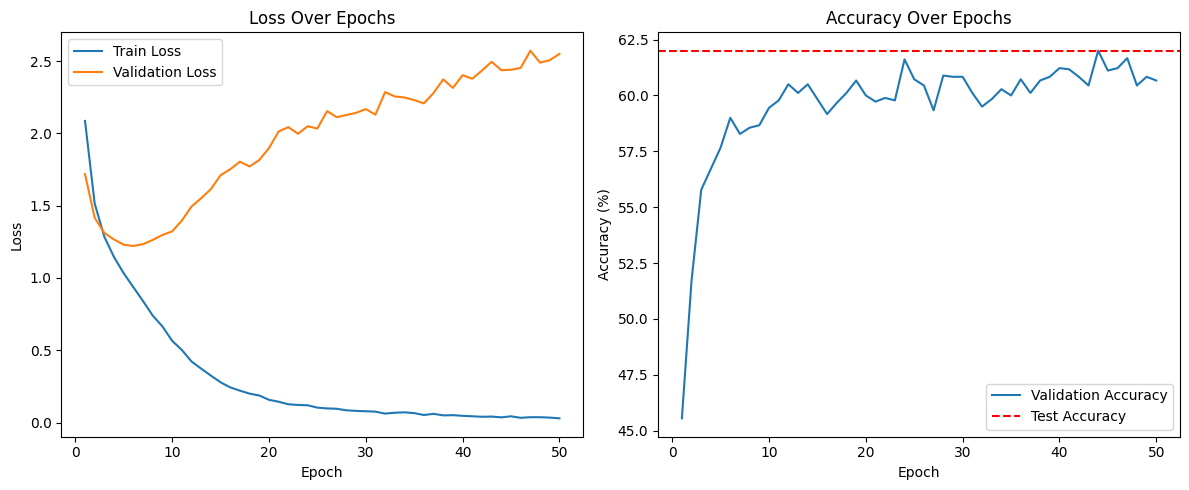

In [ ]:
# رسم نمودار دقت و Loss
def plot_metrics(train_losses, val_losses, val_accuracies, test_accuracy):
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(12, 5))

    # نمودار Loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label="Train Loss")
    plt.plot(epochs, val_losses, label="Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Loss Over Epochs")
    plt.legend()

    # نمودار Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, val_accuracies, label="Validation Accuracy")
    plt.axhline(y=test_accuracy, color='r', linestyle='--', label="Test Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy (%)")
    plt.title("Accuracy Over Epochs")
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_metrics(train_losses, val_losses, val_accuracies, test_accuracy)


In [ ]:
from sklearn.metrics import classification_report

# ارزیابی مدل EfficientNet-B0 با نمایش دقت هر دسته
def evaluate_efficientnet_model_per_category(model, test_loader):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to("cuda" if torch.cuda.is_available() else "cpu"), labels.to("cuda" if torch.cuda.is_available() else "cpu")
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # نمایش دقت کلی
    accuracy = accuracy_score(all_labels, all_preds)
    print(f"Overall Accuracy: {accuracy * 100:.2f}%")

    # نمایش دقت هر دسته با استفاده از classification_report
    category_names = dataset.categories  # نام دسته‌ها از داده‌ها
    report = classification_report(all_labels, all_preds, target_names=category_names)
    print("\nCategory-wise Accuracy:\n", report)

# فراخوانی تابع ارزیابی
evaluate_efficientnet_model_per_category(efficientnet_model, test_loader)

Overall Accuracy: 62.00%

Category-wise Accuracy:
               precision    recall  f1-score   support

         326       0.50      0.38      0.43       180
         365       0.64      0.69      0.66       180
         322       0.50      0.51      0.50       180
         312       0.71      0.73      0.72       180
         311       0.69      0.64      0.66       180
         315       0.50      0.61      0.55       180
         321       0.43      0.34      0.38       180
         313       0.70      0.73      0.72       180
         324       0.83      0.78      0.81       180
         325       0.66      0.79      0.72       180

    accuracy                           0.62      1800
   macro avg       0.62      0.62      0.62      1800
weighted avg       0.62      0.62      0.62      1800



In [ ]:
from torchvision import models
import torch.nn as nn
import torch.optim as optim

# تعریف مدل
densenet_model = models.densenet201(weights='IMAGENET1K_V1')  # استفاده از DenseNet-201
num_features = densenet_model.classifier.in_features
num_classes = len(set(dataset.labels))  # تعداد کلاس‌ها (بر اساس داده‌های شما)
densenet_model.classifier = nn.Linear(num_features, num_classes)
densenet_model = densenet_model.to("cuda")

# فریز کردن لایه‌های اولیه
for param in densenet_model.features.parameters():
  param.requires_grad = False

# تعریف Criterion و Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(densenet_model.parameters(), lr=0.0001)

# آموزش مدل
train_losses, val_losses, val_accuracies = train_model_with_validation(
    densenet_model, train_loader, val_loader, criterion, optimizer
)

Epoch 1/50, Train Loss: 2.0728, Val Loss: 1.8178, Val Accuracy: 41.39%
Epoch 2/50, Train Loss: 1.7096, Val Loss: 1.6068, Val Accuracy: 47.44%


KeyboardInterrupt: 

In [ ]:
from torchvision import models
import torch.nn as nn
import torch.optim as optim

# مدل EfficientNet-B4
efficientnet_model = models.efficientnet_b4(weights='IMAGENET1K_V1')
num_features = efficientnet_model.classifier[1].in_features
num_classes = len(set(dataset.labels))  # تعداد کلاس‌ها
efficientnet_model.classifier[1] = nn.Linear(num_features, num_classes)
efficientnet_model = efficientnet_model.to("cuda")

# Criterion و Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(efficientnet_model.parameters(), lr=0.00005)  # AdamW برای همگرایی بهتر

# آموزش مدل
train_losses, val_losses, val_accuracies = train_model_with_validation(
    efficientnet_model, train_loader, val_loader, criterion, optimizer
)


Downloading: "https://download.pytorch.org/models/efficientnet_b4_rwightman-23ab8bcd.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b4_rwightman-23ab8bcd.pth
100%|██████████| 74.5M/74.5M [00:01<00:00, 46.3MB/s]


Epoch 1/50, Train Loss: 2.2198, Val Loss: 2.0860, Val Accuracy: 38.11%
Epoch 2/50, Train Loss: 1.8990, Val Loss: 1.6990, Val Accuracy: 46.00%
Epoch 3/50, Train Loss: 1.5618, Val Loss: 1.4707, Val Accuracy: 50.56%
Epoch 4/50, Train Loss: 1.3819, Val Loss: 1.3694, Val Accuracy: 51.94%
Epoch 5/50, Train Loss: 1.2924, Val Loss: 1.3622, Val Accuracy: 53.83%
Epoch 6/50, Train Loss: 1.2061, Val Loss: 1.2706, Val Accuracy: 55.50%
Epoch 7/50, Train Loss: 1.1434, Val Loss: 1.2408, Val Accuracy: 56.67%
Epoch 8/50, Train Loss: 1.0880, Val Loss: 1.2402, Val Accuracy: 56.39%
Epoch 9/50, Train Loss: 1.0228, Val Loss: 1.2192, Val Accuracy: 57.72%
Epoch 10/50, Train Loss: 0.9679, Val Loss: 1.2128, Val Accuracy: 57.50%


KeyboardInterrupt: 

In [ ]:
import os
import shutil

# مسیر فولدر خروجی
output_dir = "/content/misclassified_images"
os.makedirs(output_dir, exist_ok=True)

# ایجاد فولدرها برای هر کلاس
classes = dataset.categories  # اسامی کلاس‌ها از دیتاست
for cls in classes:
    os.makedirs(os.path.join(output_dir, cls), exist_ok=True)


In [ ]:
def save_misclassified_images(model, data_loader, output_dir, classes):
    model.eval()
    with torch.no_grad():
        for images, labels, paths in data_loader:  # مسیر فایل‌ها از اینجا دریافت می‌شود
            images, labels = images.to("cuda"), labels.to("cuda")
            outputs = model(images).logits
            probs = torch.softmax(outputs, dim=1)
            _, preds = torch.max(outputs, 1)

            for path, label, pred, prob in zip(paths, labels, preds, probs):
                if label != pred:
                    pred_prob = prob[pred].item() * 100
                    file_name = f"{pred_prob:.2f}_{os.path.basename(path)}_{classes[pred]}.jpg"
                    dest_folder = os.path.join(output_dir, classes[label])
                    os.makedirs(dest_folder, exist_ok=True)
                    dest_path = os.path.join(dest_folder, file_name)
                    shutil.copy(path, dest_path)




In [ ]:
class CustomDataset(Dataset):
    def __init__(self, image_dir, transform=None):
        self.image_dir = image_dir
        self.transform = transform
        self.images = []
        self.labels = []
        self.categories = os.listdir(image_dir)

        # خواندن تصاویر و برچسب‌ها
        for label, category in enumerate(self.categories):
            category_path = os.path.join(image_dir, category)
            for image_name in os.listdir(category_path):
                if image_name.endswith(".jpg") or image_name.endswith(".png"):
                    self.images.append((os.path.join(category_path, image_name), label))  # مسیر و برچسب

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path, label = self.images[idx]
        img = Image.open(img_path).convert("RGB")

        if self.transform:
            img = self.transform(img)

        return img, label, img_path  # بازگشت مسیر فایل




In [ ]:
# بازسازی دیتاست‌ها با کلاس جدید

# بارگذاری داده‌ها
image_dir = "/content/images_files/good_images"
dataset = CustomDataset(image_dir, transform)


# تقسیم‌بندی داده‌ها به Train، Validation و Test
train_data, temp_data = train_test_split(dataset, test_size=0.3, stratify=dataset.labels)
val_data, test_data = train_test_split(temp_data, test_size=0.5, stratify=[d[1] for d in temp_data])
# بازسازی DataLoader‌ها
train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)
img, label, path = dataset[0]
print(f"Path: {path}, Label: {label}")


ValueError: Found array with 0 sample(s) (shape=(0,)) while a minimum of 1 is required.

In [ ]:
# ذخیره تصاویر اشتباه برای داده‌های Test
output_dir = "/content/misclassified_images"
save_misclassified_images(model, test_loader, output_dir, dataset.categories)
print(f"Misclassified images saved in {output_dir}")


ValueError: not enough values to unpack (expected 3, got 2)

In [ ]:
from torchvision.models.vision_transformer import vit_b_16

# مدل Vision Transformer
vit_model = vit_b_16(weights='IMAGENET1K_V1')
num_features = vit_model.heads.head.in_features
num_classes = len(set(dataset.labels))  # تعداد کلاس‌ها
vit_model.heads.head = nn.Linear(num_features, num_classes)
vit_model = vit_model.to("cuda")

# Criterion و Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(vit_model.parameters(), lr=0.00005)

# آموزش مدل
train_losses, val_losses, val_accuracies = train_model_with_validation(
    vit_model, train_loader, val_loader, criterion, optimizer
)


TypeError: pic should be PIL Image or ndarray. Got <class 'torch.Tensor'>

In [ ]:
#good
# مدل DenseNet-201
densenet_model = models.densenet201(weights='IMAGENET1K_V1')
num_features = densenet_model.classifier.in_features
num_classes = len(set(dataset.labels))  # تعداد کلاس‌ها
densenet_model.classifier = nn.Linear(num_features, num_classes)
densenet_model = densenet_model.to("cuda")

# Criterion و Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(densenet_model.parameters(), lr=0.00001)

# آموزش مدل
train_losses, val_losses, val_accuracies = train_model_with_validation(
    densenet_model, train_loader, val_loader, criterion, optimizer
)

Downloading: "https://download.pytorch.org/models/densenet201-c1103571.pth" to /root/.cache/torch/hub/checkpoints/densenet201-c1103571.pth
100%|██████████| 77.4M/77.4M [00:00<00:00, 141MB/s]


Epoch 1/20, Train Loss: 0.6853, Val Loss: 0.4230, Val Accuracy: 85.59%
Epoch 2/20, Train Loss: 0.2191, Val Loss: 0.4142, Val Accuracy: 87.40%
Epoch 3/20, Train Loss: 0.0965, Val Loss: 0.4844, Val Accuracy: 86.06%
Epoch 4/20, Train Loss: 0.0541, Val Loss: 0.5265, Val Accuracy: 86.99%


KeyboardInterrupt: 

In [ ]:
#good
# ارزیابی روی داده‌های Test
def evaluate_model_on_test(model, test_loader):
    model.eval()
    test_loss = 0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to("cuda"), labels.to("cuda")
            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    test_accuracy = accuracy_score(all_labels, all_preds)
    print(f"Test Loss: {test_loss / len(test_loader):.4f}, Test Accuracy: {test_accuracy * 100:.2f}%")
    return test_loss / len(test_loader), test_accuracy * 100

test_loss, test_accuracy = evaluate_model_on_test(densenet_model, test_loader)

Test Loss: 0.4365, Test Accuracy: 87.58%


In [ ]:
# مدل DenseNet-201
densenet_model = models.densenet201(weights='IMAGENET1K_V1')
num_features = densenet_model.classifier.in_features
num_classes = len(set(dataset.labels))  # تعداد کلاس‌ها
densenet_model.classifier = nn.Linear(num_features, num_classes)
densenet_model = densenet_model.to("cuda")

# Criterion و Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(densenet_model.parameters(), lr=0.0001)

# آموزش مدل
train_losses, val_losses, val_accuracies = train_model_with_validation(
    densenet_model, train_loader, val_loader, criterion, optimizer
)

Epoch 1/20, Train Loss: 1.3423, Val Loss: 1.0968, Val Accuracy: 63.44%
Epoch 2/20, Train Loss: 0.6885, Val Loss: 1.1084, Val Accuracy: 64.06%
Epoch 3/20, Train Loss: 0.3106, Val Loss: 1.2198, Val Accuracy: 64.00%
Epoch 4/20, Train Loss: 0.1417, Val Loss: 1.3004, Val Accuracy: 64.00%
Epoch 5/20, Train Loss: 0.0849, Val Loss: 1.4742, Val Accuracy: 64.06%
Epoch 6/20, Train Loss: 0.0910, Val Loss: 1.5222, Val Accuracy: 63.22%
Epoch 7/20, Train Loss: 0.1093, Val Loss: 1.5999, Val Accuracy: 62.22%
Epoch 8/20, Train Loss: 0.0788, Val Loss: 1.6566, Val Accuracy: 62.94%


KeyboardInterrupt: 

In [ ]:
# مدل DenseNet-201
densenet_model = models.densenet201(weights='IMAGENET1K_V1')
num_features = densenet_model.classifier.in_features
num_classes = len(set(dataset.labels))  # تعداد کلاس‌ها
densenet_model.classifier = nn.Linear(num_features, num_classes)

# فریز کردن همه لایه‌ها جز لایه‌ی آخر
for param in densenet_model.parameters():
    param.requires_grad = False
for param in densenet_model.classifier.parameters():
    param.requires_grad = True

densenet_model = densenet_model.to("cuda")

# Criterion و Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(densenet_model.classifier.parameters(), lr=0.0001)

# آموزش مدل
train_losses, val_losses, val_accuracies = train_model_with_validation(
    densenet_model, train_loader, val_loader, criterion, optimizer
)


Epoch 1/20, Train Loss: 2.0861, Val Loss: 1.8808, Val Accuracy: 39.28%
Epoch 2/20, Train Loss: 1.7213, Val Loss: 1.6593, Val Accuracy: 46.39%
Epoch 3/20, Train Loss: 1.5459, Val Loss: 1.5445, Val Accuracy: 51.00%
Epoch 4/20, Train Loss: 1.4484, Val Loss: 1.4769, Val Accuracy: 53.06%
Epoch 5/20, Train Loss: 1.3931, Val Loss: 1.4408, Val Accuracy: 53.61%


KeyboardInterrupt: 

In [ ]:
# مدل DenseNet-201
densenet_model = models.densenet201(weights='IMAGENET1K_V1')
num_features = densenet_model.classifier.in_features
num_classes = len(set(dataset.labels))  # تعداد کلاس‌ها
densenet_model.classifier = nn.Linear(num_features, num_classes)

# فریز کردن تمام لایه‌ها
for param in densenet_model.parameters():
    param.requires_grad = False

# باز کردن آموزش فقط 5 لایه‌ی آخر
for name, param in list(densenet_model.named_parameters())[-10:]:
    param.requires_grad = True
    print(f"Training layer: {name}")  # برای اطمینان از لایه‌های باز

densenet_model = densenet_model.to("cuda")

# Criterion و Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(filter(lambda p: p.requires_grad, densenet_model.parameters()), lr=0.0001)

# آموزش مدل
train_losses, val_losses, val_accuracies = train_model_with_validation(
    densenet_model, train_loader, val_loader, criterion, optimizer
)


Training layer: features.denseblock4.denselayer32.norm1.weight
Training layer: features.denseblock4.denselayer32.norm1.bias
Training layer: features.denseblock4.denselayer32.conv1.weight
Training layer: features.denseblock4.denselayer32.norm2.weight
Training layer: features.denseblock4.denselayer32.norm2.bias
Training layer: features.denseblock4.denselayer32.conv2.weight
Training layer: features.norm5.weight
Training layer: features.norm5.bias
Training layer: classifier.weight
Training layer: classifier.bias
Epoch 1/20, Train Loss: 1.9786, Val Loss: 1.6830, Val Accuracy: 47.06%
Epoch 2/20, Train Loss: 1.5254, Val Loss: 1.4267, Val Accuracy: 54.17%
Epoch 3/20, Train Loss: 1.3232, Val Loss: 1.3134, Val Accuracy: 57.33%
Epoch 4/20, Train Loss: 1.1804, Val Loss: 1.2451, Val Accuracy: 58.83%
Epoch 5/20, Train Loss: 1.0625, Val Loss: 1.2052, Val Accuracy: 59.39%


KeyboardInterrupt: 

In [ ]:
# مدل ResNet-101
resnet_model = models.resnet101(weights='IMAGENET1K_V1')
num_features = resnet_model.fc.in_features
num_classes = len(set(dataset.labels))  # تعداد کلاس‌ها
resnet_model.fc = nn.Linear(num_features, num_classes)

# فریز کردن تمام لایه‌ها
for param in resnet_model.parameters():
    param.requires_grad = False

# باز کردن آموزش فقط 5 لایه‌ی آخر
for name, param in list(resnet_model.named_parameters())[-10:]:
    param.requires_grad = True
    print(f"Training layer: {name}")  # برای اطمینان از لایه‌های باز

resnet_model = resnet_model.to("cuda")

# Criterion و Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(filter(lambda p: p.requires_grad, resnet_model.parameters()), lr=0.001, momentum=0.9, weight_decay=1e-4)

# آموزش مدل
train_losses, val_losses, val_accuracies = train_model_with_validation(
    resnet_model, train_loader, val_loader, criterion, optimizer
)


Downloading: "https://download.pytorch.org/models/resnet101-63fe2227.pth" to /root/.cache/torch/hub/checkpoints/resnet101-63fe2227.pth
100%|██████████| 171M/171M [00:01<00:00, 137MB/s]


Training layer: layer4.2.bn1.weight
Training layer: layer4.2.bn1.bias
Training layer: layer4.2.conv2.weight
Training layer: layer4.2.bn2.weight
Training layer: layer4.2.bn2.bias
Training layer: layer4.2.conv3.weight
Training layer: layer4.2.bn3.weight
Training layer: layer4.2.bn3.bias
Training layer: fc.weight
Training layer: fc.bias
Epoch 1/20, Train Loss: 1.5784, Val Loss: 1.3977, Val Accuracy: 53.56%
Epoch 2/20, Train Loss: 1.2908, Val Loss: 1.3165, Val Accuracy: 55.39%
Epoch 3/20, Train Loss: 1.1963, Val Loss: 1.3190, Val Accuracy: 55.94%
Epoch 4/20, Train Loss: 1.1185, Val Loss: 1.3045, Val Accuracy: 55.44%
Epoch 5/20, Train Loss: 1.0417, Val Loss: 1.2920, Val Accuracy: 57.33%


KeyboardInterrupt: 

In [ ]:
# ارزیابی روی داده‌های Test
def evaluate_model_on_test(model, test_loader):
    model.eval()
    test_loss = 0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to("cuda"), labels.to("cuda")
            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    test_accuracy = accuracy_score(all_labels, all_preds)
    print(f"Test Loss: {test_loss / len(test_loader):.4f}, Test Accuracy: {test_accuracy * 100:.2f}%")
    return test_loss / len(test_loader), test_accuracy * 100

test_loss, test_accuracy = evaluate_model_on_test(efficientnet_model, test_loader)


Test Loss: 1.2659, Test Accuracy: 58.33%


In [ ]:
# رسم نمودار دقت و Loss
def plot_metrics(train_losses, val_losses, val_accuracies, test_accuracy):
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(12, 5))

    # نمودار Loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label="Train Loss")
    plt.plot(epochs, val_losses, label="Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Loss Over Epochs")
    plt.legend()

    # نمودار Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, val_accuracies, label="Validation Accuracy")
    plt.axhline(y=test_accuracy, color='r', linestyle='--', label="Test Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy (%)")
    plt.title("Accuracy Over Epochs")
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_metrics(train_losses, val_losses, val_accuracies, test_accuracy)


NameError: name 'train_losses' is not defined

In [ ]:
from sklearn.metrics import classification_report

# ارزیابی مدل EfficientNet-B0 با نمایش دقت هر دسته
def evaluate_efficientnet_model_per_category(model, test_loader):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to("cuda" if torch.cuda.is_available() else "cpu"), labels.to("cuda" if torch.cuda.is_available() else "cpu")
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # نمایش دقت کلی
    accuracy = accuracy_score(all_labels, all_preds)
    print(f"Overall Accuracy: {accuracy * 100:.2f}%")

    # نمایش دقت هر دسته با استفاده از classification_report
    category_names = dataset.categories  # نام دسته‌ها از داده‌ها
    report = classification_report(all_labels, all_preds, target_names=category_names)
    print("\nCategory-wise Accuracy:\n", report)

# فراخوانی تابع ارزیابی
evaluate_efficientnet_model_per_category(efficientndensenet_modelet_model, test_loader)

NameError: name 'efficientnet_model' is not defined

In [ ]:
from timm import create_model
import torch.nn as nn
import torch.optim as optim

# تعریف مدل EfficientNet-V2
efficientnet_v2 = create_model("tf_efficientnetv2_m", pretrained=True, num_classes=num_classes)

# Freeze کردن لایه‌های اولیه
for param in efficientnet_v2.parameters():
    param.requires_grad = False

# بازکردن لایه‌های classifier برای آموزش
for param in efficientnet_v2.classifier.parameters():
    param.requires_grad = True

# انتقال مدل به GPU
efficientnet_v2 = efficientnet_v2.to("cuda")

# تعریف Criterion و Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(efficientnet_v2.parameters(), lr=0.0001)

# آموزش مدل
train_losses, val_losses, val_accuracies = train_model_with_validation(
    efficientnet_v2, train_loader, val_loader, criterion, optimizer
)


Epoch 1/50, Train Loss: 9.8844, Val Loss: 8.8529, Val Accuracy: 12.39%
Epoch 2/50, Train Loss: 8.7091, Val Loss: 7.9209, Val Accuracy: 13.78%
Epoch 3/50, Train Loss: 7.9967, Val Loss: 7.4751, Val Accuracy: 15.67%
Epoch 4/50, Train Loss: 7.4834, Val Loss: 7.2452, Val Accuracy: 16.83%
Epoch 5/50, Train Loss: 7.0167, Val Loss: 6.9099, Val Accuracy: 19.39%
Epoch 6/50, Train Loss: 6.5866, Val Loss: 6.5609, Val Accuracy: 20.39%
Epoch 7/50, Train Loss: 6.2558, Val Loss: 6.2674, Val Accuracy: 22.33%
Epoch 8/50, Train Loss: 5.9871, Val Loss: 6.0011, Val Accuracy: 23.94%
Epoch 9/50, Train Loss: 5.6796, Val Loss: 5.8262, Val Accuracy: 25.67%
Epoch 10/50, Train Loss: 5.5138, Val Loss: 5.5999, Val Accuracy: 26.44%
Epoch 11/50, Train Loss: 5.3256, Val Loss: 5.4837, Val Accuracy: 27.11%
Epoch 12/50, Train Loss: 5.0504, Val Loss: 5.3411, Val Accuracy: 28.06%
Epoch 13/50, Train Loss: 4.9867, Val Loss: 5.1893, Val Accuracy: 29.17%
Epoch 14/50, Train Loss: 4.8048, Val Loss: 4.9918, Val Accuracy: 30.22%
E

In [ ]:
# ارزیابی روی داده‌های Test
def evaluate_model_on_test(model, test_loader):
    model.eval()
    test_loss = 0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to("cuda"), labels.to("cuda")
            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    test_accuracy = accuracy_score(all_labels, all_preds)
    print(f"Test Loss: {test_loss / len(test_loader):.4f}, Test Accuracy: {test_accuracy * 100:.2f}%")
    return test_loss / len(test_loader), test_accuracy * 100

test_loss, test_accuracy = evaluate_model_on_test(efficientnet_model, test_loader)


Test Loss: 2.4605, Test Accuracy: 62.00%


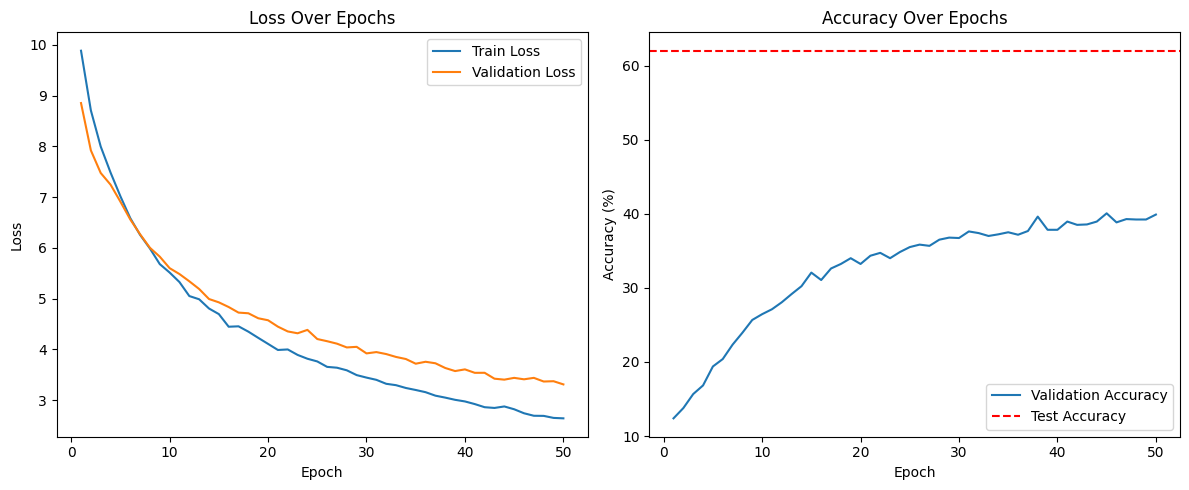

In [ ]:
# رسم نمودار دقت و Loss
def plot_metrics(train_losses, val_losses, val_accuracies, test_accuracy):
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(12, 5))

    # نمودار Loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label="Train Loss")
    plt.plot(epochs, val_losses, label="Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Loss Over Epochs")
    plt.legend()

    # نمودار Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, val_accuracies, label="Validation Accuracy")
    plt.axhline(y=test_accuracy, color='r', linestyle='--', label="Test Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy (%)")
    plt.title("Accuracy Over Epochs")
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_metrics(train_losses, val_losses, val_accuracies, test_accuracy)


In [ ]:
from sklearn.metrics import classification_report

# ارزیابی مدل EfficientNet-B0 با نمایش دقت هر دسته
def evaluate_efficientnet_model_per_category(model, test_loader):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to("cuda" if torch.cuda.is_available() else "cpu"), labels.to("cuda" if torch.cuda.is_available() else "cpu")
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # نمایش دقت کلی
    accuracy = accuracy_score(all_labels, all_preds)
    print(f"Overall Accuracy: {accuracy * 100:.2f}%")

    # نمایش دقت هر دسته با استفاده از classification_report
    category_names = dataset.categories  # نام دسته‌ها از داده‌ها
    report = classification_report(all_labels, all_preds, target_names=category_names)
    print("\nCategory-wise Accuracy:\n", report)

# فراخوانی تابع ارزیابی
evaluate_efficientnet_model_per_category(efficientnet_model, test_loader)

NameError: name 'efficientnet_model' is not defined

In [ ]:

# تعریف تنظیمات و پارامترها
IMAGE_SIZE = 128
BATCH_SIZE = 32
EPOCHS = 20
LEARNING_RATE = 0.001

In [ ]:
# تابع آموزش مدل
def train_model_with_validation(model, train_loader, val_loader, criterion, optimizer, epochs=EPOCHS):
    train_losses = []
    val_losses = []
    val_accuracies = []

    for epoch in range(epochs):
        model.train()
        train_loss = 0

        # آموزش روی داده‌های Train
        for images, labels in train_loader:
            images, labels = images.to("cuda"), labels.to("cuda")
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        train_losses.append(train_loss / len(train_loader))

        # ارزیابی روی داده‌های Validation
        model.eval()
        val_loss = 0
        all_preds = []
        all_labels = []
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to("cuda"), labels.to("cuda")
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, preds = torch.max(outputs, 1)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        val_losses.append(val_loss / len(val_loader))
        val_accuracy = accuracy_score(all_labels, all_preds)
        val_accuracies.append(val_accuracy * 100)

        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}, Val Accuracy: {val_accuracy * 100:.2f}%")

    return train_losses, val_losses, val_accuracies


In [ ]:
# تعریف مدل
efficientnet_model = models.efficientnet_b0(weights='IMAGENET1K_V1')
for param in efficientnet_model.parameters():
    param.requires_grad = False  # فریز کردن لایه‌های ابتدایی

# باز کردن دو لایه آخر برای یادگیری
for param in list(efficientnet_model.classifier[-2:].parameters()):
    param.requires_grad = True

# تنظیم لایه‌های نهایی
num_features = efficientnet_model.classifier[1].in_features
efficientnet_model.classifier[1] = nn.Linear(num_features, len(dataset.categories))

# آموزش مدل EfficientNet-B0
efficientnet_model = efficientnet_model.to("cuda" if torch.cuda.is_available() else "cpu")

# تعریف Criterion و Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(efficientnet_model.parameters(), lr=0.001)

# آموزش مدل
train_losses, val_losses, val_accuracies = train_model_with_validation(
    efficientnet_model, train_loader, val_loader, criterion, optimizer
)




Epoch 1/20, Train Loss: 1.7573, Val Loss: 1.5431, Val Accuracy: 49.44%
Epoch 2/20, Train Loss: 1.4970, Val Loss: 1.4899, Val Accuracy: 49.17%
Epoch 3/20, Train Loss: 1.4298, Val Loss: 1.4480, Val Accuracy: 51.33%
Epoch 4/20, Train Loss: 1.4125, Val Loss: 1.4503, Val Accuracy: 51.39%
Epoch 5/20, Train Loss: 1.3697, Val Loss: 1.4480, Val Accuracy: 52.28%
Epoch 6/20, Train Loss: 1.3534, Val Loss: 1.4530, Val Accuracy: 51.17%
Epoch 7/20, Train Loss: 1.3466, Val Loss: 1.4521, Val Accuracy: 51.56%
Epoch 8/20, Train Loss: 1.3429, Val Loss: 1.4499, Val Accuracy: 51.78%
Epoch 9/20, Train Loss: 1.3410, Val Loss: 1.4520, Val Accuracy: 52.00%
Epoch 10/20, Train Loss: 1.3340, Val Loss: 1.4418, Val Accuracy: 51.83%
Epoch 11/20, Train Loss: 1.3393, Val Loss: 1.4644, Val Accuracy: 51.67%
Epoch 12/20, Train Loss: 1.3330, Val Loss: 1.4567, Val Accuracy: 51.17%
Epoch 13/20, Train Loss: 1.3211, Val Loss: 1.4568, Val Accuracy: 51.22%
Epoch 14/20, Train Loss: 1.3349, Val Loss: 1.4595, Val Accuracy: 51.89%
E

In [ ]:
# ارزیابی روی داده‌های Test
def evaluate_model_on_test(model, test_loader):
    model.eval()
    test_loss = 0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to("cuda"), labels.to("cuda")
            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    test_accuracy = accuracy_score(all_labels, all_preds)
    print(f"Test Loss: {test_loss / len(test_loader):.4f}, Test Accuracy: {test_accuracy * 100:.2f}%")
    return test_loss / len(test_loader), test_accuracy * 100

test_loss, test_accuracy = evaluate_model_on_test(efficientnet_model, test_loader)


Test Loss: 1.4490, Test Accuracy: 50.50%


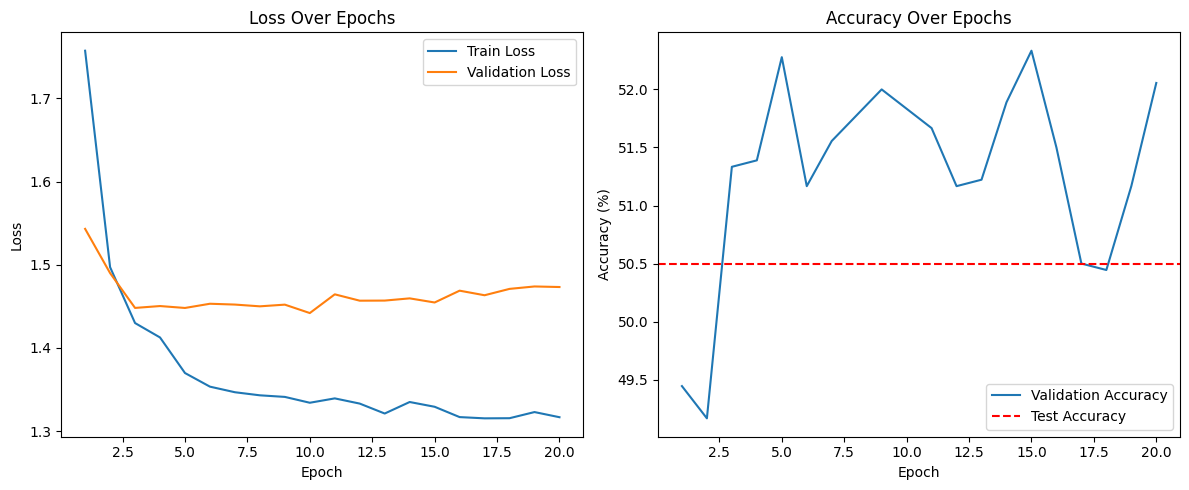

In [ ]:
# رسم نمودار دقت و Loss
def plot_metrics(train_losses, val_losses, val_accuracies, test_accuracy):
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(12, 5))

    # نمودار Loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label="Train Loss")
    plt.plot(epochs, val_losses, label="Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Loss Over Epochs")
    plt.legend()

    # نمودار Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, val_accuracies, label="Validation Accuracy")
    plt.axhline(y=test_accuracy, color='r', linestyle='--', label="Test Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy (%)")
    plt.title("Accuracy Over Epochs")
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_metrics(train_losses, val_losses, val_accuracies, test_accuracy)


In [ ]:
from sklearn.metrics import classification_report

# ارزیابی مدل EfficientNet-B0 با نمایش دقت هر دسته
def evaluate_efficientnet_model_per_category(model, test_loader):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to("cuda" if torch.cuda.is_available() else "cpu"), labels.to("cuda" if torch.cuda.is_available() else "cpu")
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # نمایش دقت کلی
    accuracy = accuracy_score(all_labels, all_preds)
    print(f"Overall Accuracy: {accuracy * 100:.2f}%")

    # نمایش دقت هر دسته با استفاده از classification_report
    category_names = dataset.categories  # نام دسته‌ها از داده‌ها
    report = classification_report(all_labels, all_preds, target_names=category_names)
    print("\nCategory-wise Accuracy:\n", report)

# فراخوانی تابع ارزیابی
evaluate_efficientnet_model_per_category(efficientnet_model, test_loader)

Overall Accuracy: 50.50%

Category-wise Accuracy:
               precision    recall  f1-score   support

         326       0.36      0.42      0.39       180
         365       0.51      0.57      0.54       180
         322       0.41      0.37      0.39       180
         312       0.56      0.60      0.58       180
         311       0.57      0.62      0.59       180
         315       0.44      0.48      0.46       180
         321       0.37      0.26      0.30       180
         313       0.60      0.58      0.59       180
         324       0.62      0.66      0.64       180
         325       0.61      0.49      0.55       180

    accuracy                           0.51      1800
   macro avg       0.50      0.51      0.50      1800
weighted avg       0.50      0.51      0.50      1800



#انتخاب بهترین مدل آموزش و ارزیابی و ذخیره وزن ها

In [ ]:
from transformers import ViTForImageClassification, ViTFeatureExtractor
import torch
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from PIL import Image
import os
import numpy as np

# تنظیمات مدل
IMAGE_SIZE = 224  # تغییر به 224x224 برای ViT
BATCH_SIZE = 32
EPOCHS = 20
LEARNING_RATE = 0.0001

# 1. آماده‌سازی داده‌ها
class CustomDataset(Dataset):
    def __init__(self, image_dir, transform=None):
        self.image_dir = image_dir
        self.transform = transform
        self.images = []
        self.labels = []
        self.categories = os.listdir(image_dir)

        # خواندن تصاویر و برچسب‌ها
        for label, category in enumerate(self.categories):
            category_path = os.path.join(image_dir, category)
            for image_name in os.listdir(category_path):
                if image_name.endswith(".jpg") or image_name.endswith(".png"):
                    self.images.append(os.path.join(category_path, image_name))
                    self.labels.append(label)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images[idx]
        label = self.labels[idx]
        img = Image.open(img_path).convert("RGB")

        if self.transform:
            img = self.transform(img)

        return img, label

# استفاده از ViTFeatureExtractor برای تغییرات مناسب
feature_extractor = ViTFeatureExtractor.from_pretrained("google/vit-base-patch16-224-in21k")
transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=feature_extractor.image_mean, std=feature_extractor.image_std),
])

# بارگذاری داده‌ها
image_dir = "/content/images_files/good_images"
dataset = CustomDataset(image_dir, transform)

# تقسیم داده‌ها به Train، Validation و Test
train_data, temp_data = train_test_split(dataset, test_size=0.3, stratify=dataset.labels)
val_data, test_data = train_test_split(temp_data, test_size=0.5, stratify=[d[1] for d in temp_data])

train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)

# 2. تعریف مدل ViT
model = ViTForImageClassification.from_pretrained(
    "google/vit-base-patch16-224-in21k",
    num_labels=len(set(dataset.labels))  # تعداد کلاس‌ها
)
model = model.to("cuda")

# 3. تعریف Criterion و Optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

# 4. تابع آموزش
def train_model_with_validation(model, train_loader, val_loader, criterion, optimizer, epochs=EPOCHS):
    train_losses = []
    val_losses = []
    val_accuracies = []

    for epoch in range(epochs):
        model.train()
        train_loss = 0

        # آموزش روی داده‌های Train
        for images, labels in train_loader:
            images, labels = images.to("cuda"), labels.to("cuda")
            optimizer.zero_grad()
            outputs = model(images).logits
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        train_losses.append(train_loss / len(train_loader))

        # ارزیابی روی داده‌های Validation
        model.eval()
        val_loss = 0
        all_preds = []
        all_labels = []
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to("cuda"), labels.to("cuda")
                outputs = model(images).logits
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, preds = torch.max(outputs, 1)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        val_losses.append(val_loss / len(val_loader))
        val_accuracy = accuracy_score(all_labels, all_preds)
        val_accuracies.append(val_accuracy * 100)

        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}, Val Accuracy: {val_accuracy * 100:.2f}%")

    return train_losses, val_losses, val_accuracies

# آموزش مدل
train_losses, val_losses, val_accuracies = train_model_with_validation(
    model, train_loader, val_loader, criterion, optimizer
)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/20, Train Loss: 0.6380, Val Loss: 0.2368, Val Accuracy: 94.64%
Epoch 2/20, Train Loss: 0.1414, Val Loss: 0.2448, Val Accuracy: 93.42%
Epoch 3/20, Train Loss: 0.0653, Val Loss: 0.2094, Val Accuracy: 94.19%
Epoch 4/20, Train Loss: 0.0388, Val Loss: 0.1940, Val Accuracy: 94.96%
Epoch 5/20, Train Loss: 0.0186, Val Loss: 0.3290, Val Accuracy: 92.38%
Epoch 6/20, Train Loss: 0.0256, Val Loss: 0.3146, Val Accuracy: 92.12%
Epoch 7/20, Train Loss: 0.0337, Val Loss: 0.2439, Val Accuracy: 93.87%
Epoch 8/20, Train Loss: 0.0489, Val Loss: 0.2304, Val Accuracy: 93.67%
Epoch 9/20, Train Loss: 0.0192, Val Loss: 0.2126, Val Accuracy: 94.84%
Epoch 10/20, Train Loss: 0.0085, Val Loss: 0.2079, Val Accuracy: 94.77%
Epoch 11/20, Train Loss: 0.0031, Val Loss: 0.2012, Val Accuracy: 94.77%
Epoch 12/20, Train Loss: 0.0016, Val Loss: 0.2023, Val Accuracy: 95.03%
Epoch 13/20, Train Loss: 0.0012, Val Loss: 0.2053, Val Accuracy: 95.29%
Epoch 14/20, Train Loss: 0.0010, Val Loss: 0.2087, Val Accuracy: 95.35%
E

In [ ]:
# ذخیره مدل
torch.save(model.state_dict(), "vit_model.pth")
print("مدل ذخیره شد.")


مدل ذخیره شد.


In [ ]:
# مسیر ذخیره مدل در گوگل درایو
save_path = '/content/drive/MyDrive/vit_model.pth'

# ذخیره مدل آموزش‌دیده
torch.save(model.state_dict(), save_path)
print(f"Model saved to {save_path}")


Model saved to /content/drive/MyDrive/vit_model.pth


In [ ]:
# ارزیابی روی داده‌های تست
def evaluate_model(model, data_loader, criterion):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to("cuda"), labels.to("cuda")
            outputs = model(images).logits
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = correct / total * 100
    print(f"Test Loss: {total_loss / len(data_loader):.4f}, Test Accuracy: {accuracy:.2f}%")
    return accuracy, all_preds, all_labels

test_accuracy, test_preds, test_labels = evaluate_model(model, test_loader, criterion)


Test Loss: 0.3063, Test Accuracy: 94.26%


In [ ]:
# تابع محاسبه دقت کلی و دقت هر کلاس
def evaluate_class_accuracy(model, data_loader, classes):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to("cuda"), labels.to("cuda")
            outputs = model(images).logits
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # دقت کلی
    overall_accuracy = accuracy_score(all_labels, all_preds) * 100

    # دقت برای هر کلاس
    class_accuracies = compute_class_accuracy(all_preds, all_labels, classes)
    return overall_accuracy, class_accuracies

# محاسبه دقت برای داده‌های Train
train_accuracy, train_class_accuracy = evaluate_class_accuracy(model, train_loader, classes)
print("\nTrain Data:")
print(f"Overall Accuracy: {train_accuracy:.2f}%")
for cls, acc in train_class_accuracy.items():
    print(f"{cls}: {acc:.2f}%")

# محاسبه دقت برای داده‌های Validation
val_accuracy, val_class_accuracy = evaluate_class_accuracy(model, val_loader, classes)
print("\nValidation Data:")
print(f"Overall Accuracy: {val_accuracy:.2f}%")
for cls, acc in val_class_accuracy.items():
    print(f"{cls}: {acc:.2f}%")

# محاسبه دقت برای داده‌های Test
test_accuracy, test_class_accuracy = evaluate_class_accuracy(model, test_loader, classes)
print("\nTest Data:")
print(f"Overall Accuracy: {test_accuracy:.2f}%")
for cls, acc in test_class_accuracy.items():
    print(f"{cls}: {acc:.2f}%")



Train Data:
Overall Accuracy: 100.00%
403: 100.00%
248: 100.00%
300: 100.00%
372: 100.00%
357: 100.00%
242: 100.00%
321: 100.00%
311: 100.00%
358: 100.00%
365: 100.00%

Validation Data:
Overall Accuracy: 95.67%
403: 94.41%
248: 98.78%
300: 99.39%
372: 84.21%
357: 98.06%
242: 100.00%
321: 92.86%
311: 98.44%
358: 97.40%
365: 91.14%

Test Data:
Overall Accuracy: 94.26%
403: 93.79%
248: 100.00%
300: 99.40%
372: 78.20%
357: 98.70%
242: 98.31%
321: 87.01%
311: 98.43%
358: 97.42%
365: 88.61%


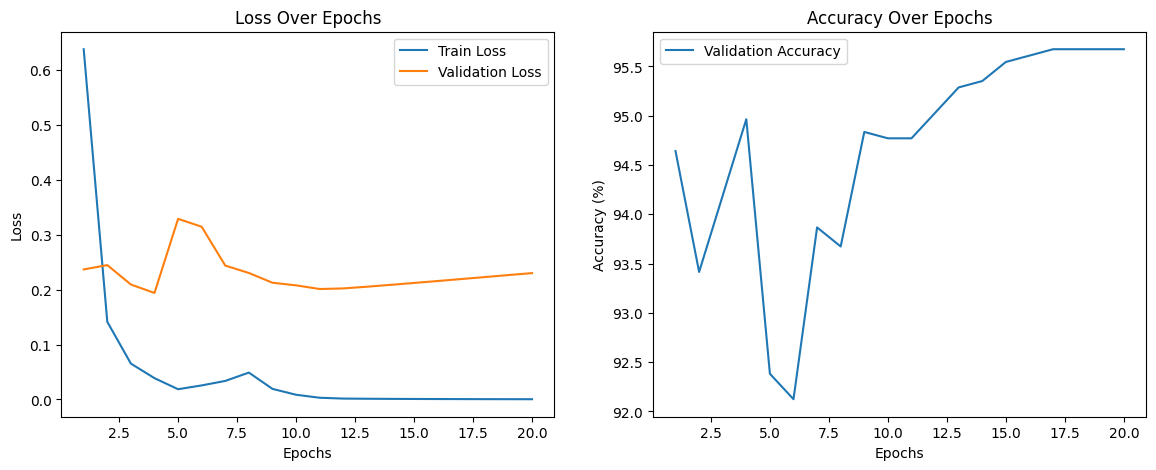

In [ ]:
import matplotlib.pyplot as plt

# رسم نمودار دقت و Loss
def plot_metrics(train_losses, val_losses, val_accuracies):
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(14, 5))

    # Loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label="Train Loss")
    plt.plot(epochs, val_losses, label="Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Loss Over Epochs")
    plt.legend()

    # Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, val_accuracies, label="Validation Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy (%)")
    plt.title("Accuracy Over Epochs")
    plt.legend()

    plt.show()

plot_metrics(train_losses, val_losses, val_accuracies)


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-7-6a67dc9d6c62>:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_global

مدل بارگذاری شد.
Total Misclassified Images: 89


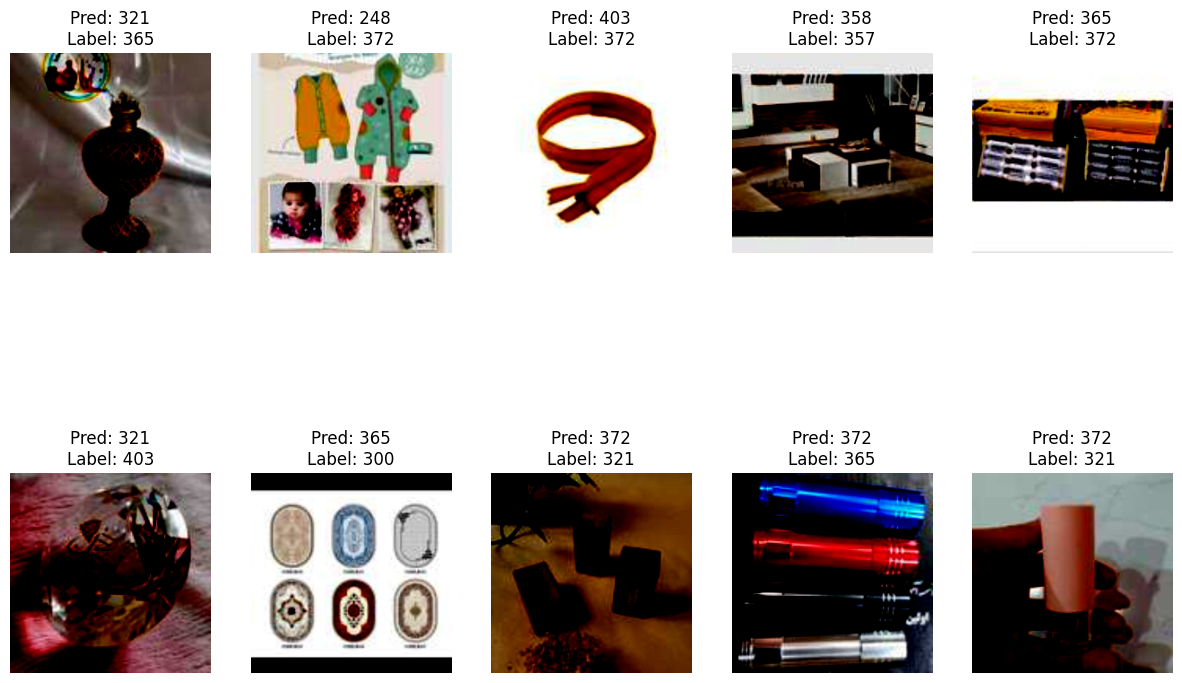

In [ ]:
# بارگذاری مدل ذخیره‌شده
model = ViTForImageClassification.from_pretrained(
    "google/vit-base-patch16-224-in21k",
    num_labels=len(classes)
)
model.load_state_dict(torch.load("vit_model.pth"))
model = model.to("cuda")
print("مدل بارگذاری شد.")

# نمایش نمونه‌های اشتباه
def show_misclassified_images(model, data_loader, classes):
    model.eval()
    misclassified = []

    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to("cuda"), labels.to("cuda")
            outputs = model(images).logits
            _, preds = torch.max(outputs, 1)
            for img, pred, label in zip(images.cpu(), preds.cpu(), labels.cpu()):
                if pred != label:
                    misclassified.append((img, pred, label))

    print(f"Total Misclassified Images: {len(misclassified)}")
    return misclassified

misclassified_images = show_misclassified_images(model, test_loader, classes)

# نمایش چند تصویر اشتباه
def plot_misclassified_images(misclassified_images, classes, num_images=10):
    plt.figure(figsize=(15, 10))

    for i, (img, pred, label) in enumerate(misclassified_images[:num_images]):
        img = img.permute(1, 2, 0).numpy()
        img = np.clip(img, 0, 1)

        plt.subplot(2, 5, i + 1)
        plt.imshow(img)
        plt.title(f"Pred: {classes[pred]}\nLabel: {classes[label]}")
        plt.axis("off")

    plt.show()

plot_misclassified_images(misclassified_images, classes)
